In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, callbacks
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [3]:
img_height, img_width = 32, 32
batch_size = 20

In [4]:
# Change the following paths to the correct paths where your shared dataset is located
train_dir = '/gdrive/My Drive/ProjectImage/Skin_Disease_Dataset/training'
test_dir = '/gdrive/My Drive/ProjectImage/Skin_Disease_Dataset/testing'
validation_dir = '/gdrive/My Drive/ProjectImage/Skin_Disease_Dataset/validation'

In [5]:
# Load the datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size
)
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 178 files belonging to 2 classes.
Found 32 files belonging to 2 classes.
Found 36 files belonging to 2 classes.


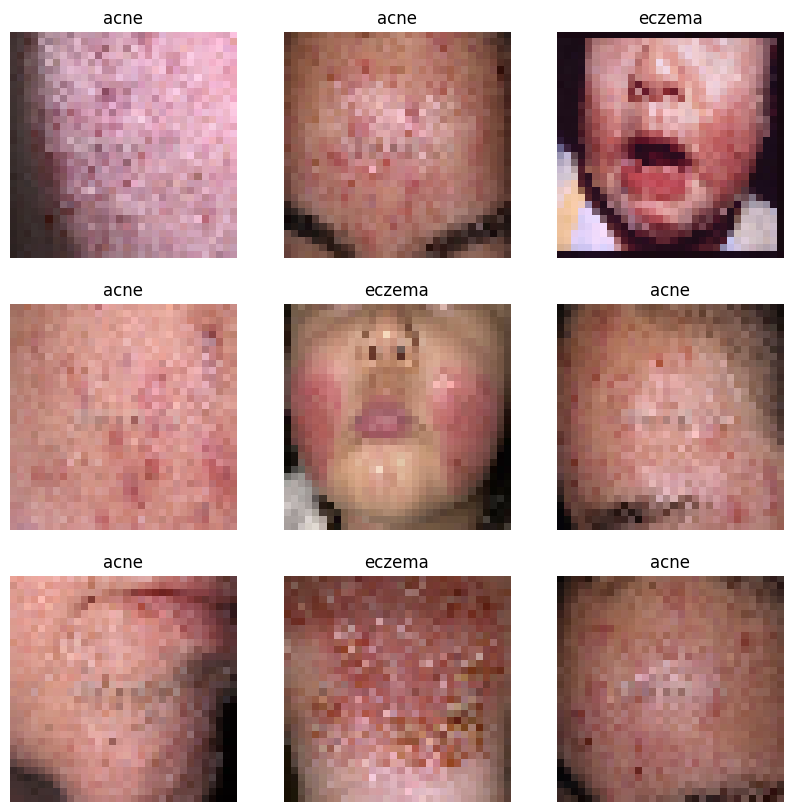

In [6]:
# Display some training images with their labels
class_names = ["acne", "eczema"]
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [7]:
# Build the model with Dropout layers to prevent overfitting
model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),  # Rescale pixel values
    layers.Conv2D(32, (3, 3), activation='relu'),  # First convolutional layer
    layers.MaxPooling2D(),  # First max-pooling layer
    layers.Dropout(0.2),  # Dropout layer
    layers.Conv2D(64, (3, 3), activation='relu'),  # Second convolutional layer
    layers.MaxPooling2D(),  # Second max-pooling layer
    layers.Dropout(0.2),  # Dropout layer
    layers.Conv2D(128, (3, 3), activation='relu'),  # Third convolutional layer
    layers.MaxPooling2D(),  # Third max-pooling layer
    layers.Dropout(0.2),  # Dropout layer
    layers.Flatten(),  # Flatten the output for the fully connected layer
    layers.Dense(128, activation='relu'),  # Fully connected layer
    layers.Dropout(0.5),  # Dropout layer
    layers.Dense(2)  # Output layer
])

In [8]:
# Compile the model with Adam optimizer and sparse categorical cross-entropy loss
model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [9]:
# Early stopping callback to prevent overfitting by stopping training early
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [26]:
# Train the model and save the training history for visualization
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[early_stopping]
)

Epoch 1/30
9/9 [==============================] - 1s 21ms/step - loss: 0.3173 - accuracy: 0.8764 - val_loss: 0.4134 - val_accuracy: 0.8125
Epoch 2/30
9/9 [==============================] - 1s 24ms/step - loss: 0.2697 - accuracy: 0.8876 - val_loss: 0.4062 - val_accuracy: 0.8125
Epoch 3/30
9/9 [==============================] - 1s 51ms/step - loss: 0.2874 - accuracy: 0.8652 - val_loss: 0.4055 - val_accuracy: 0.8438
Epoch 4/30
9/9 [==============================] - 1s 49ms/step - loss: 0.3301 - accuracy: 0.8596 - val_loss: 0.4194 - val_accuracy: 0.7812
Epoch 5/30
9/9 [==============================] - 1s 52ms/step - loss: 0.2868 - accuracy: 0.8764 - val_loss: 0.4340 - val_accuracy: 0.7812
Epoch 6/30
9/9 [==============================] - 1s 48ms/step - loss: 0.2429 - accuracy: 0.9213 - val_loss: 0.3496 - val_accuracy: 0.8750
Epoch 7/30
9/9 [==============================] - 1s 20ms/step - loss: 0.2391 - accuracy: 0.8989 - val_loss: 0.3642 - val_accuracy: 0.8750
Epoch 8/30
9/9 [===========

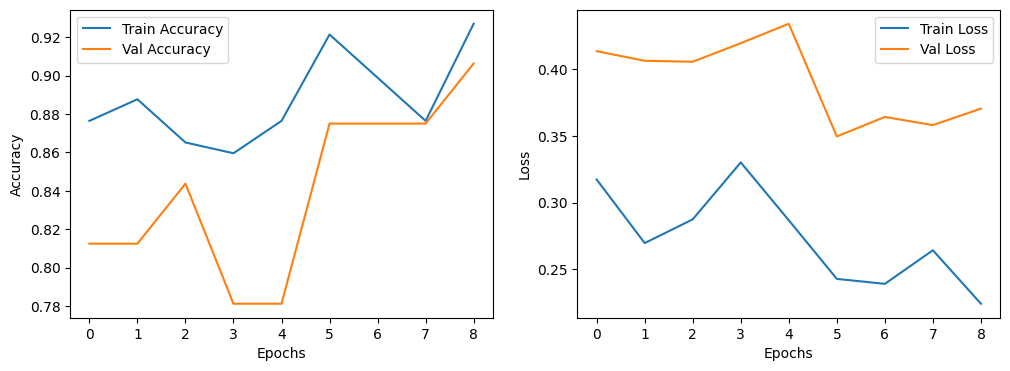

In [27]:
# Plot training and validation accuracy and loss over epochs
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [28]:
# Print the final validation accuracy
final_val_accuracy = history.history['val_accuracy'][-1]
print(f'Final Validation Accuracy: {final_val_accuracy:.4f}')

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_ds)
print(f'Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}')

Final Validation Accuracy: 0.9062
2/2 [==============================] - 0s 11ms/step - loss: 0.2944 - accuracy: 0.8889
Test Accuracy: 0.8889, Test Loss: 0.2944


In [29]:
# Generate detailed classification report and confusion matrix
all_labels = []
all_predictions = []
for images, labels in test_ds:
    predictions = model.predict(images)
    all_labels.extend(labels)
    all_predictions.extend(np.argmax(predictions, axis=1))

# Convert to numpy arrays
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

print(classification_report(all_labels, all_predictions, target_names=class_names))

1/1 [==============================] - 0s 17ms/step
              precision    recall  f1-score   support

        acne       0.94      0.83      0.88        18
      eczema       0.85      0.94      0.89        18

    accuracy                           0.89        36
   macro avg       0.89      0.89      0.89        36
weighted avg       0.89      0.89      0.89        36



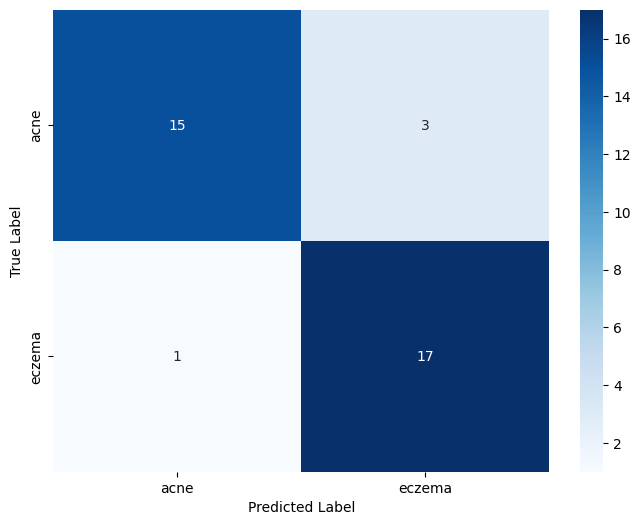

In [30]:
# Plot confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

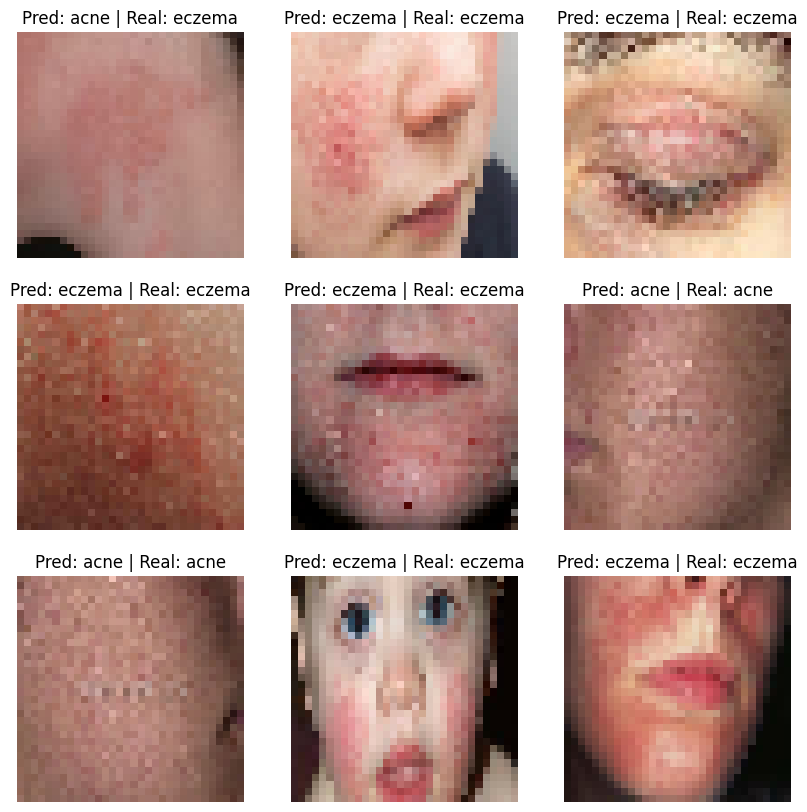

In [31]:
# Visualize predictions on some test images
plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
    classifications = model(images)

    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        index = np.argmax(classifications[i])
        plt.title(f"Pred: {class_names[index]} | Real: {class_names[labels[i]]}")
        plt.axis("off")